In [1]:
# Load modules
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
import datajoint as dj
from datetime import datetime
from pathlib import Path
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import workflow
from matplotlib import pyplot as plt
import spikeinterface as si
from spikeinterface import widgets, exporters, postprocessing, qualitymetrics, sorters
import probeinterface as pi
from probeinterface import plotting
from workflow.pipeline import *
from workflow.utils.ingestion_utils import El2ROW
from workflow.utils.paths import (
    get_ephys_root_data_dir,
    get_raw_root_data_dir,
    get_processed_root_data_dir,
)
from element_interface.utils import dict_to_uuid, find_full_path, find_root_directory, _to_Path
import seaborn as sns

[2024-03-20 12:57:54,206][INFO]: Connecting judewerth@db.datajoint.com:3306
[2024-03-20 12:57:54,937][INFO]: Connected judewerth@db.datajoint.com:3306


In [2]:
# Parameters
organoids = ["O09" , "O10" , "O11" , "O12" , "O13" , "O14" , "O15" , "O16" , "O17" , "O18" , "O19" , "O20"]
drugs = ["4-AP" , "No Drug" , "Bicuculline" , "Tetrodotoxin"]

In [3]:
# Check dataset (if statements)
for organoid in organoids:
    for drug in drugs:

        datapath = get_processed_root_data_dir() / "spike_sorting" / organoid / drug

        output = os.listdir(datapath)

        if not "recording.pkl" in os.listdir(datapath / output[0]):
            print(f"organoid id = {organoid} , drug = {drug} doesn't contain recording.pkl")

        if len(output) != 1:
            print(f"organoid id = {organoid} , drug = {drug} has {len(output)} outputs")




In [3]:
from IPython.display import clear_output


data = {}
for organoid in organoids:
    print(organoid)

    for drug in drugs:
        print(drug)

        path = get_processed_root_data_dir() / "spike_sorting" / organoid / drug
        output = os.listdir(path)[0]
        datapath = path / output

        # Get and filter recording data
        raw_recording = si.load_extractor(datapath / "recording.pkl")
        recording_f = si.preprocessing.bandpass_filter(recording=raw_recording, freq_min=300, freq_max=6000)
        recording = si.preprocessing.common_reference(recording=recording_f, operator="median")
        print("recording finished")

        # Get sorting data
        sorting = si.load_extractor(datapath / "sorting.pkl")
        print("sorting finished")

        # Get waveform data
        waveforms = si.load_waveforms(datapath / "waveform", with_recording=True)
        print("waveforms finished")

        # Get Firing Rate
        metrics = si.qualitymetrics.compute_quality_metrics(
            waveforms,
            metric_names=["firing_rate"])
        print("metrics finished")

        # Add to dictionary
        title = f"{organoid}({drug})"
        data[title] = list(metrics.firing_rate)

    clear_output(wait = False)
    

In [ ]:
firing_rate_dict = batch1 | batch2 | batch3 


In [ ]:
# import pickle

# file = open(get_processed_root_data_dir() / "outputs" / "32chanFR.pkl" , "wb")
# pickle.dump(firing_rate_dict , file=file)
# file.close()


198.99000000000007

In [6]:
# Get Data
import pickle
import numpy as np

# Load Data
f = open(get_processed_root_data_dir() / "outputs" / "32chanFR.pkl" , "rb")
frdict = pickle.load(f)
# frdict = 48 key dictionary (O09->O20 for each drug treatment) which contains all unit firing rates for that section

# Sum all unit firing rates for each organoid
batches = {
    "b1" : organoids[:4],
    "b2" : organoids[4:8],
    "b3" : organoids[8:]
}   

batch_data = {} # 12 key dictionary (each batch and each drug treatment) contains the sum of all units for each organoid within the batch
for b , org in batches.items():
    for drug in drugs:
        
        batch_data[f"{b}({drug})"] = []

        for o in org:
            batch_data[f"{b}({drug})"].append(sum(frdict[f"{o}({drug})"])) # sums all the units into a single firing rate


drug_data = {} # 4 key dictionary (each drug) which contains the average organoid firing rate for each batch (list of 3 values)

for drug in drugs:

    drug_data[drug] = []
    for batch in batches:
        drug_data[drug].append(np.mean(batch_data[f"{batch}({drug})"])) # averages organoid firing rates
    



            

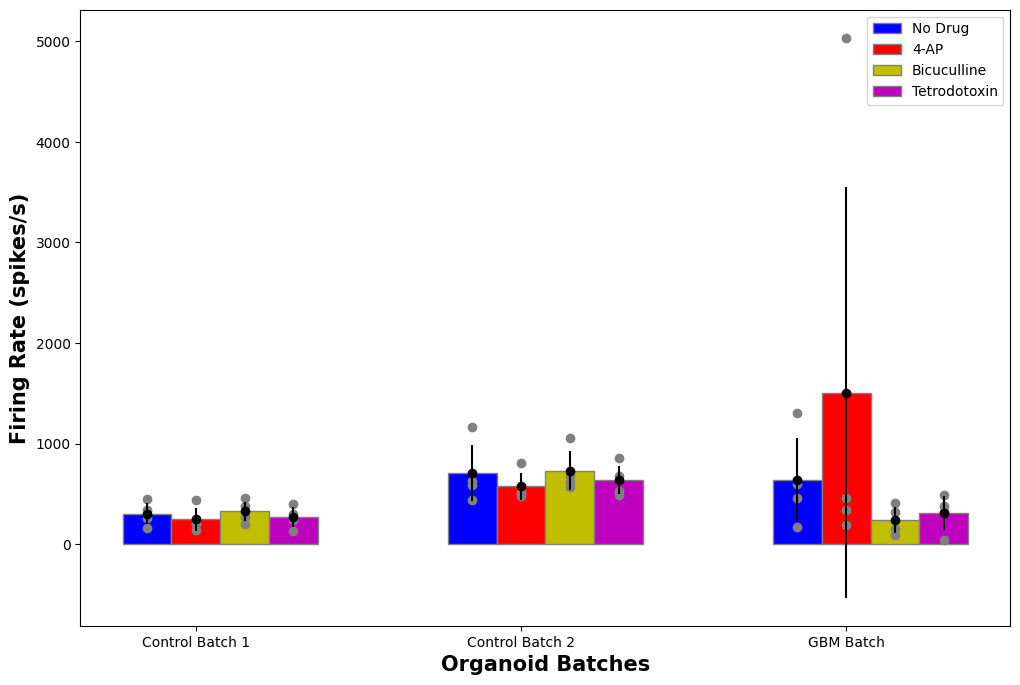

In [7]:
# Plot Data
from matplotlib import pyplot as plt

# labels
dlabel = ["No Drug" , "4-AP", "Bicuculline" , "Tetrodotoxin"]
blabel = ["Control Batch 1" , "Control Batch 2" , "GBM Batch"]
colors = ['b' , 'r' , 'y' , 'm']

# figure info
barWidth = 0.15
fig = plt.subplots(figsize =(12, 8)) 
B = 3 # number of batches

# plot
bar = list(range(B)) # number of batches (x-axis)

for idx , drug in enumerate(dlabel):

    # plot bars
    plt.bar(bar, drug_data[drug], color = colors[idx] , width = barWidth, edgecolor ='grey', label = drug) 

    # find errorbar values (standard deviation) and plot datapoints
    std = []
    for idx , batch in enumerate(batches):
        bdata = batch_data[f"{batch}({drug})"]
        std.append(np.std(bdata))

        plt.scatter([bar[idx]]*len(bdata) , bdata , color = 'gray')

    # plot errorbars
    plt.errorbar(bar, drug_data[drug], yerr=std, fmt="o", color="k")
    # advance bar index (x-axis)
    bar = [x + barWidth for x in bar]



# Adding Xticks 
plt.xlabel('Organoid Batches', fontweight ='bold', fontsize = 15) 
plt.ylabel('Firing Rate (spikes/s)', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(B)] , blabel) 

plt.legend()
plt.show() 

In [36]:
# Remove Channels outside of the Organoid

# sample data
path = get_processed_root_data_dir() / "spike_sorting" / "O10" / "No Drug"
output = os.listdir(path)[0]
datapath = path / output

raw_recording = si.load_extractor(datapath / "recording.pkl")
recording_f = si.preprocessing.bandpass_filter(recording=raw_recording, freq_min=300, freq_max=6000)
recording = si.preprocessing.common_reference(recording=recording_f, operator="median")

sorting = si.load_extractor(datapath / "sorting.pkl")

waveforms = si.load_waveforms(datapath / "waveform", with_recording=True)



In [51]:
# find channels outside of the organoid
el = 16 # number of electrodes inside the organoid
used_electrodes = El2ROW[:el].tolist()
el_idx = recording.get_channel_ids()[0].astype(int)

used_electrodes += el_idx
recording2 = recording.remove_channels(remove_channel_ids=np.array([str(elec) for elec in recording.get_channel_ids() if int(elec) not in used_electrodes]))

probe1 = pi.generate_linear_probe(num_elec=recording.get_num_channels() , ypitch=100 , contact_shape_params={'radius': 15})
probe1.set_device_channel_indices(np.arange(recording.get_num_channels()))
recording = recording.set_probe(probe=probe1)

probe2 = pi.generate_linear_probe(num_elec=recording2.get_num_channels() , ypitch=100 , contact_shape_params={'radius': 15})
probe2.set_device_channel_indices(np.arange(recording2.get_num_channels()))
recording2 = recording2.set_probe(probe=probe2)



waveforms = si.extract_waveforms(
        recording,
        sorting,
        folder = get_processed_root_data_dir() / "test",
        ms_before=1.5,
        ms_after=2.,
        max_spikes_per_unit=500,
        overwrite=True, 
       )

waveforms2 = si.extract_waveforms(
        recording2,
        sorting,
        folder = get_processed_root_data_dir() / "test",
        ms_before=1.5,
        ms_after=2.,
        max_spikes_per_unit=500,
        overwrite=True, 
       )

metrics = si.qualitymetrics.compute_quality_metrics(
    waveforms,
    metric_names=["firing_rate"])
metrics2 = si.qualitymetrics.compute_quality_metrics(
    waveforms2,
    metric_names=["firing_rate"])

extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

In [53]:
metrics.firing_rate

0      6.413333
1      6.856667
2     13.116667
3     24.140000
4      7.996667
5      5.760000
6      7.350000
7      8.990000
8     20.293333
9     13.100000
10     8.440000
11     5.770000
12     6.836667
13    26.403333
Name: firing_rate, dtype: float64

In [100]:
from spikeinterface import WaveformExtractor as we
ui = sorting.unit_ids
waveform = si.WaveformExtractor(recording=recording , sorting=sorting , folder=get_processed_root_data_dir()/"test")
waveform.
a = we.get_waveforms(unit_id = ui[0] , self = waveform , with_index=True)
print(a[1])
# prints out (time,location) I need to set the probe up so this will reveal which channels each waveform comes from, hopefully I can filter from there


[(   4, 0) (   8, 0) (  13, 0) (  14, 0) (  21, 0) (  22, 0) (  23, 0)
 (  30, 0) (  36, 0) (  44, 0) (  52, 0) (  57, 0) (  66, 0) (  71, 0)
 (  76, 0) (  79, 0) (  90, 0) (  91, 0) (  95, 0) (  98, 0) (  99, 0)
 ( 100, 0) ( 104, 0) ( 107, 0) ( 110, 0) ( 113, 0) ( 114, 0) ( 118, 0)
 ( 119, 0) ( 120, 0) ( 127, 0) ( 131, 0) ( 132, 0) ( 137, 0) ( 141, 0)
 ( 142, 0) ( 147, 0) ( 150, 0) ( 151, 0) ( 152, 0) ( 153, 0) ( 156, 0)
 ( 157, 0) ( 159, 0) ( 160, 0) ( 167, 0) ( 173, 0) ( 176, 0) ( 179, 0)
 ( 185, 0) ( 190, 0) ( 192, 0) ( 196, 0) ( 199, 0) ( 208, 0) ( 209, 0)
 ( 210, 0) ( 213, 0) ( 217, 0) ( 222, 0) ( 229, 0) ( 230, 0) ( 231, 0)
 ( 235, 0) ( 237, 0) ( 238, 0) ( 248, 0) ( 252, 0) ( 255, 0) ( 256, 0)
 ( 259, 0) ( 261, 0) ( 263, 0) ( 264, 0) ( 265, 0) ( 266, 0) ( 271, 0)
 ( 280, 0) ( 281, 0) ( 286, 0) ( 288, 0) ( 294, 0) ( 296, 0) ( 301, 0)
 ( 302, 0) ( 313, 0) ( 318, 0) ( 320, 0) ( 324, 0) ( 325, 0) ( 336, 0)
 ( 337, 0) ( 350, 0) ( 352, 0) ( 357, 0) ( 358, 0) ( 362, 0) ( 373, 0)
 ( 387